In [ ]:
import operator
from functools import partial

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pysm3
import tools as tl
from hwp_models import (
    ListToStokesOperator,
    MixedStokesOperator,
    StokesToListOperator,
    angles_HF,
    angles_MF,
    thicknesses,
    thicknesses_HF,
)
from pysm3 import units as u

from furax import HomothetyOperator
from furax.core._blocks import BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator
from furax.obs.landscapes import Stokes
from furax.obs.stokes import StokesIQU

In [2]:
NSIDE   = 32
NFREQ   = 20
ANGLE_INCIDENCE = 5.0
shape = (hp.nside2npix(NSIDE),)
keys = ["MF1", "MF2", "UHF1", "UHF2"]
frequency_channels = [92.0, 148.0, 225.5, 286.5]
frequency_dict = dict(zip(keys, frequency_channels))

dust_nu0 = 148.
synchrotron_nu0 = None
best_params = {"beta_dust": 1.54}

In [3]:
def Operator(params):
    Op_list = []

    for nu_x, (key, value) in enumerate(frequency_dict.items()):
        freq    = value
        epsilon = 1.0
        phi     = 0.
        bp_arrays_uKCMB = tl.get_bp_uKCMB(freq, NFREQ)

        AOp     = tl.eval_A(params, dust_nu0,bp_arrays_uKCMB[0], in_structure)
    
        ListOp = StokesToListOperator(axis=0, in_structure=AOp.out_structure())
        hwp_list = []
        if 'UHF' in key:
            thickness = thicknesses_HF[3]
            alpha_2 = angles_HF[4]
        
        else: 
            thickness = thicknesses[3]
            alpha_2 = angles_MF[4]

        for nu in bp_arrays_uKCMB[0]:
            # Create HWP operator for this frequency
            hwp_list.append(MixedStokesOperator.create(
                shape=shape,
                stokes='IQU',
                frequency=nu,
                angleIncidence=ANGLE_INCIDENCE,
                epsilon=epsilon,
                phi=phi, 
                thickness=thickness,
                alpha_2=alpha_2
            ))
            
        HDiag = BlockDiagonalOperator([hwp_list[i] for i in range(NFREQ)])
        # print(f'HWP in structure: {HDiag.out_structure()}')
        BP = bp_arrays_uKCMB[1]
        # BP[nfreq//2] = 1.0
        
        # print(bp_arrays_uKCMB[0][nfreq//2])
        STRUCT = StokesIQU.structure_for(shape=(hp.nside2npix(NSIDE),), dtype=np.float64)
        Bandpass_RowOp = BlockRowOperator([HomothetyOperator(BP[i]/np.sum(BP),STRUCT) 
                                           for i in range (BP.size)])

        Op = Bandpass_RowOp  @ HDiag @ ListOp  @ AOp
        Op_list.append(Op)

    OpBlock     = BlockColumnOperator([Op_list[i] for i in range (len(Op_list))])
    StokesOp    = ListToStokesOperator(axis=0, in_structure=OpBlock.out_structure())
    BMA = StokesOp @ OpBlock

    return BMA

In [4]:
cmb_sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1"], output_unit=u.uK_CMB)
dust_sky = pysm3.Sky(nside=NSIDE, preset_strings=["d0"], output_unit=u.uK_CMB)

cmb_maps = np.zeros((len(frequency_channels), 3,hp.nside2npix(NSIDE)))
dust_maps = np.zeros((len(frequency_channels), 3,hp.nside2npix(NSIDE)))

for i, f in enumerate(frequency_channels):
    cmb_maps[i] = cmb_sky.get_emission(f * u.GHz )
    dust_maps[i] = dust_sky.get_emission(f * u.GHz )


cmb_input = cmb_sky.get_emission(148 * u.GHz )
dust_input = dust_sky.get_emission(148 * u.GHz )


s_cmb   = Stokes.from_stokes(I=cmb_input[0]*0, Q=cmb_input[1], U=cmb_input[2])
s_dust  = Stokes.from_stokes(I=dust_input[0]*0, Q=dust_input[1], U=dust_input[2])

s= {'cmb':s_cmb, 'dust':s_dust}

in_structure = s_cmb.structure_for(s_cmb.shape,)
print(in_structure)

StokesIQU(i=ShapeDtypeStruct(shape=(12288,), dtype=float64), q=ShapeDtypeStruct(shape=(12288,), dtype=float64), u=ShapeDtypeStruct(shape=(12288,), dtype=float64))


In [5]:
BMA_op = Operator(best_params)
c4s4_maps = BMA_op(s)

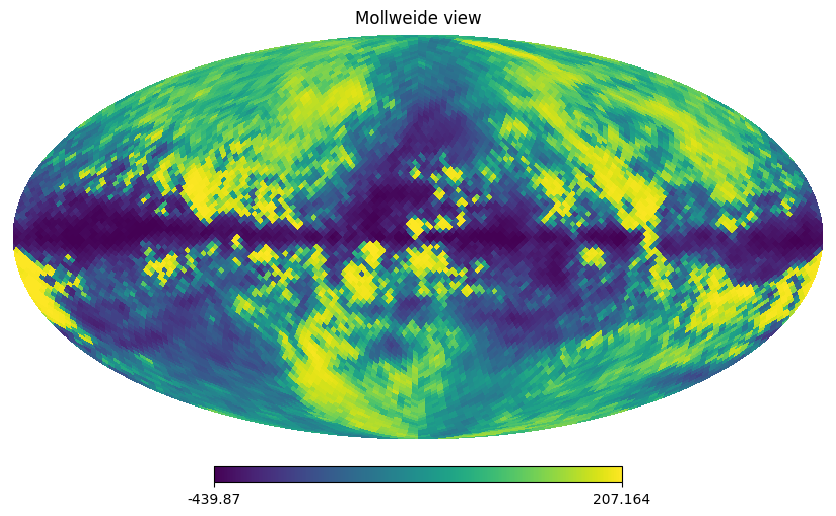

In [6]:
hp.mollview(c4s4_maps.q[3], norm='hist')

In [7]:
invN = HomothetyOperator(jnp.ones(1), _in_structure=BMA_op.T.in_structure())
DND = invN(c4s4_maps) @ c4s4_maps

In [8]:
#@jax.jit  # JIT compilation for performance
def negative_log_prob(params, d):
    """
    Compute negative log-likelihood for component separation.
    """
    # Create component operators with current parameter values
    BMA = Operator(params)

    # Compute likelihood using the marginalized form:
    # L = (A^T N^-1 d)^T (A^T N^-1 A)^-1 (A^T N^-1 d)
    x = (BMA.T @ invN)(d)  # A^T N^-1 d
    likelihood = jax.tree.map(lambda a, b: a.T @ b, x, (BMA.T @ invN @ BMA).I(x))
    summed_log_prob = jax.tree.reduce(operator.add, likelihood)

    return -summed_log_prob  # Return negative for minimization

In [9]:
#Gridding 
beta_dust_values = jnp.linspace(1.52, 1.55, 10)  

plt.figure(figsize=(12, 7))

results = {}

print("Computing NLL vs. beta_dust...")

nll_values = []

for beta_dust in beta_dust_values:
    params = {"beta_dust": beta_dust, "temp_dust": 20.0}
    nll = negative_log_prob(params, d=c4s4_maps)  
    nll_values.append(nll)

nll_values = jnp.array(nll_values)

best_idx = jnp.argmin(nll_values)
best_beta = beta_dust_values[best_idx]
best_nll = nll_values[best_idx]

results = {
    "beta_dust": beta_dust_values,
    "nll": nll_values,
    "best_beta": best_beta,
    "best_nll": best_nll,
}



print(f"Best beta_dust = {best_beta:.4f}, Min NLL = {best_nll:.4f}")


Computing NLL vs. beta_dust...
Best beta_dust = 1.5400, Min NLL = -97688397.2408


<Figure size 1200x700 with 0 Axes>

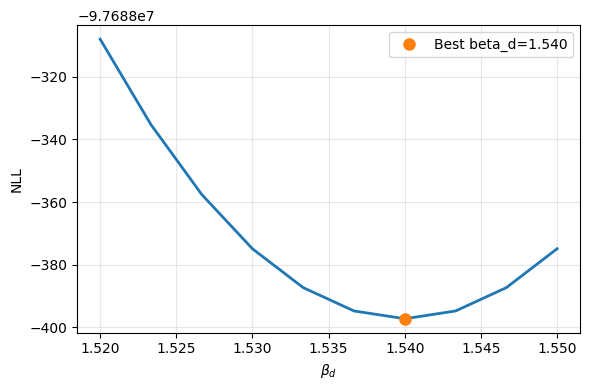

In [10]:

plt.figure(figsize=(6,4))
plt.plot(beta_dust_values, nll_values, linewidth=2)
plt.plot(best_beta, best_nll, 'o', markersize=8, label=f"Best beta_d={best_beta:.3f}")
plt.xlabel(r"$\beta_d$")
plt.ylabel("NLL")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


plt.show()

In [11]:
import time

import equinox as eqx

In [12]:
compiled = eqx.filter_jit(negative_log_prob)
start = time.time()
result1 = compiled(best_params, c4s4_maps).block_until_ready()
print(f"First run: {time.time() - start:.3f}s")


start = time.time()
result2 = negative_log_prob(best_params, c4s4_maps).block_until_ready()
print(f"Second run: {time.time() - start:.3f}s")


start = time.time()
result3 = negative_log_prob(best_params, c4s4_maps).block_until_ready()
print(f"Third run: {time.time() - start:.3f}s")

First run: 30.361s
Second run: 16.935s
Third run: 0.680s


In [13]:
#Using Wassim's generalised comp applied to HWP 
from likelihoods_hwp import negative_log_likelihood_bma


def get_nll(params, nu, N, d, dust_nu0, synchrotron_nu0):
    BMA = Operator(params)
    return negative_log_likelihood_bma(params, nu, N, d, dust_nu0, synchrotron_nu0, BMA
    )

nll_with_args = partial(
    get_nll, nu= frequency_channels, N=invN, dust_nu0=dust_nu0, synchrotron_nu0=None, 
    d=c4s4_maps)

In [14]:
compiled = eqx.filter_jit(get_nll)
start = time.time()
result1 = compiled(best_params, nu= frequency_channels, N=invN, dust_nu0=dust_nu0, 
                   synchrotron_nu0=None, d=c4s4_maps).block_until_ready()
print(f"First run: {time.time() - start:.3f}s")


start = time.time()
result2 = get_nll(best_params, nu= frequency_channels, N=invN, dust_nu0=dust_nu0, 
                  synchrotron_nu0=None, d=c4s4_maps).block_until_ready()
print(f"Second run: {time.time() - start:.3f}s")


start = time.time()
result3 = get_nll(best_params, nu= frequency_channels, N=invN, dust_nu0=dust_nu0, 
                  synchrotron_nu0=None, d=c4s4_maps).block_until_ready()
print(f"Third run: {time.time() - start:.3f}s")

First run: 30.562s
Second run: 0.689s
Third run: 0.661s


In [16]:
import optax
import optax.tree_utils as otu
from jax_grid_search import optimize

solver = optax.lbfgs()

init_params = {"beta_dust": 1.56}

final_params, final_state = optimize(
    init_params, 
    nll_with_args, 
    solver, 
    max_iter=10, 
    tol=1e-4
)

print(
    f"Final parameters: {final_params}, number of evaluations: {otu.tree_get(final_state, 'count')}"
)

2025-11-25 11:45:44.527789: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_optimize] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
